In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import pymc as pm
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = "./drive/MyDrive/Data102Project"

# Import datasets

In [ ]:
players = pd.read_csv(dir + "/NBA_players.csv", index_col=0)
players

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,42,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,34,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,12,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,7,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,22,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12839,Joel Embiid,PHI,29.0,213.36,127.005760,Kansas,Cameroon,2014,1,3,...,33.1,10.2,4.2,8.8,0.057,0.243,0.370,0.655,0.233,2022-23
12840,John Butler Jr.,POR,20.0,213.36,86.182480,Florida State,USA,Undrafted,Undrafted,Undrafted,...,2.4,0.9,0.6,-16.1,0.012,0.065,0.102,0.411,0.066,2022-23
12841,John Collins,ATL,25.0,205.74,102.511792,Wake Forest,USA,2017,1,19,...,13.1,6.5,1.2,-0.2,0.035,0.180,0.168,0.593,0.052,2022-23
12842,Jericho Sims,NYK,24.0,208.28,113.398000,Texas,USA,2021,2,58,...,3.4,4.7,0.5,-6.7,0.117,0.175,0.074,0.780,0.044,2022-23


In [ ]:
display(players.columns)
players[players["player_name"].isnull()]

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object')

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season


In [ ]:
season_stats = pd.read_csv(dir + "/Seasons_Stats.csv", index_col=0)
season_stats.drop(columns=["blanl", "blank2"], inplace=True)
season_stats

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,...,0.679,135.0,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0
24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,...,0.564,43.0,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0
24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,...,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0
24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,...,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0


In [ ]:
free_throws = pd.read_csv(dir + "/free_throws.csv")
free_throws

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,1,7:26
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,0,7:26
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2006 - 2007,1,7:18
...,...,...,...,...,...,...,...,...,...,...,...
618014,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 1 of 2,Randy Foye,playoffs,103 - 116,2015 - 2016,1,0:53
618015,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 2 of 2,Randy Foye,playoffs,103 - 117,2015 - 2016,1,0:53
618016,104 - 118,DAL - OKC,400874368.0,4.0,Kevin Durant makes technical free throw,Kevin Durant,playoffs,103 - 118,2015 - 2016,1,0:27
618017,104 - 118,DAL - OKC,400874368.0,4.0,Dwight Powell misses free throw 1 of 2,Dwight Powell,playoffs,103 - 118,2015 - 2016,0,0:26


In [ ]:
free_throws[free_throws["player"].isnull()]

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time


# Clean/transform players and join with their season-wise stats

In [ ]:
players = players[['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'season']]

players["season"] = players["season"].apply(lambda x: x[:2] + x[-2:]).astype(int)

players = players[players["draft_year"] != "Undrafted"]
players["draft_year"] = players["draft_year"].apply(lambda x: x[0:4]).astype(int)

players["exp"] = players["season"] - players["draft_year"]

players

<ipython-input-9-ee2b6815425d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players["season"] = players["season"].apply(lambda x: x[:2] + x[-2:]).astype(int)


,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,season,exp
0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,1997,1
1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,1997,3
2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1997,4
3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1997,8
4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1997,2
...,...,...,...,...,...,...,...,...,...,...
12836,Joe Harris,BKN,31.0,198.12,99.790240,Virginia,USA,2014,2023,9
12838,Joe Wieskamp,TOR,23.0,198.12,92.986360,Iowa,USA,2021,2023,2
12839,Joel Embiid,PHI,29.0,213.36,127.005760,Kansas,Cameroon,2014,2023,9
12841,John Collins,ATL,25.0,205.74,102.511792,Wake Forest,USA,2017,2023,6


In [ ]:
season_stats = season_stats.rename(columns={"Player":"player_name", "Age":"age", "Tm":"team_abbreviation"})
players_season_stats = players.merge(season_stats, on=["player_name", "age", "team_abbreviation"])
players_season_stats

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,season,exp,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1997,4,...,0.619,98.0,163.0,261.0,76.0,63.0,17.0,64.0,97.0,342.0
1,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1997,2,...,0.800,10.0,13.0,23.0,5.0,1.0,0.0,4.0,17.0,52.0
2,Gerald Wilkins,ORL,33.0,198.12,102.058200,Tennessee-Chattanooga,USA,1985,1997,12,...,0.716,59.0,114.0,173.0,173.0,54.0,12.0,123.0,144.0,848.0
3,Glen Rice,CHH,30.0,203.20,99.790240,Michigan,USA,1989,1997,8,...,0.849,89.0,264.0,353.0,182.0,77.0,22.0,182.0,200.0,1826.0
4,Glenn Robinson,MIL,24.0,200.66,106.594120,Purdue,USA,1994,1997,3,...,0.791,130.0,372.0,502.0,248.0,103.0,68.0,269.0,225.0,1689.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5794,Georgios Papagiannis,SAC,19.0,215.90,108.862080,None,Greece,2016,2017,1,...,0.857,24.0,62.0,86.0,20.0,3.0,17.0,24.0,44.0,124.0
5795,Giannis Antetokounmpo,MIL,22.0,210.82,100.697424,None,Greece,2013,2017,4,...,0.770,142.0,558.0,700.0,434.0,131.0,151.0,234.0,246.0,1832.0
5796,Gerald Henderson,PHI,29.0,195.58,97.522280,Duke,USA,2009,2017,8,...,0.806,34.0,151.0,185.0,112.0,41.0,15.0,62.0,129.0,662.0
5797,Gerald Green,BOS,31.0,200.66,92.986360,None,USA,2005,2017,12,...,0.805,17.0,68.0,85.0,33.0,9.0,7.0,25.0,48.0,262.0


In [ ]:
'''
# MOVED TO DURING BIG MERGE WITH free_throws

# Get the previous stats

players_season_stats = players_season_stats.sort_values(by=["player_name", "season"])

player_grouped = players_season_stats.groupby('player_name')
all_stats = players_season_stats.columns[1:]

for stat in all_stats:
    players_season_stats[f'prev_{stat}'] = player_grouped[stat].shift()

players_season_stats
'''

'\n# MOVED TO DURING BIG MERGE WITH free_throws\n\n# Get the previous stats\n\nplayers_season_stats = players_season_stats.sort_values(by=["player_name", "season"])\n\nplayer_grouped = players_season_stats.groupby(\'player_name\')\nall_stats = players_season_stats.columns[1:]\n\nfor stat in all_stats:\n    players_season_stats[f\'prev_{stat}\'] = player_grouped[stat].shift()\n\nplayers_season_stats\n'

In [ ]:
'''
# MOVED TO DURING BIG MERGE WITH free_throws

players_season_stats = players_season_stats.drop(columns=["prev_season"])
players_season_stats = players_season_stats.reset_index(drop=True)

# drop rows with no previous stats
players_season_stats = players_season_stats.dropna()

players_season_stats
'''

'\n# MOVED TO DURING BIG MERGE WITH free_throws\n\nplayers_season_stats = players_season_stats.drop(columns=["prev_season"])\nplayers_season_stats = players_season_stats.reset_index(drop=True)\n\n# drop rows with no previous stats\nplayers_season_stats = players_season_stats.dropna()\n\nplayers_season_stats\n'

In [ ]:
players_season_stats.columns

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'season', 'exp',
       'Year', 'Pos', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [ ]:
col_to_join = 'player_name'
player_qual_vars = ["team_abbreviation", "college", "country", "Pos"]
player_quant_vars = list(set(list(players_season_stats.columns)) - set(player_qual_vars + [col_to_join]))
assert(set(player_qual_vars + player_quant_vars + [col_to_join]) == set(players_season_stats.columns))
player_quant_vars

['GS',
 'player_height',
 'player_weight',
 'G',
 'FG',
 'FGA',
 'STL%',
 'season',
 'BLK%',
 'TRB%',
 'MP',
 'eFG%',
 'PER',
 'FT',
 'age',
 'Year',
 'OWS',
 '3P%',
 'STL',
 'TOV%',
 'USG%',
 'DWS',
 'ORB%',
 'WS/48',
 'WS',
 '3P',
 'DRB',
 '3PAr',
 '2PA',
 'BPM',
 'TRB',
 'TOV',
 'VORP',
 'PF',
 'draft_year',
 'AST%',
 'AST',
 '2P%',
 'TS%',
 'FT%',
 'OBPM',
 'ORB',
 'BLK',
 'FTr',
 'DBPM',
 'FTA',
 '3PA',
 'FG%',
 'exp',
 '2P',
 'PTS',
 'DRB%']

In [ ]:
players_season_stats = players_season_stats.dropna()
players_season_stats[player_quant_vars] = players_season_stats[player_quant_vars].apply(pd.to_numeric)
players_season_stats

<ipython-input-15-35d89d2dc968>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_season_stats[player_quant_vars] = players_season_stats[player_quant_vars].apply(pd.to_numeric)


,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,season,exp,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1997,4,...,0.619,98.0,163.0,261.0,76.0,63.0,17.0,64.0,97.0,342.0
2,Gerald Wilkins,ORL,33.0,198.12,102.058200,Tennessee-Chattanooga,USA,1985,1997,12,...,0.716,59.0,114.0,173.0,173.0,54.0,12.0,123.0,144.0,848.0
3,Glen Rice,CHH,30.0,203.20,99.790240,Michigan,USA,1989,1997,8,...,0.849,89.0,264.0,353.0,182.0,77.0,22.0,182.0,200.0,1826.0
4,Glenn Robinson,MIL,24.0,200.66,106.594120,Purdue,USA,1994,1997,3,...,0.791,130.0,372.0,502.0,248.0,103.0,68.0,269.0,225.0,1689.0
5,Grant Hill,DET,24.0,203.20,102.058200,Duke,USA,1994,1997,3,...,0.711,123.0,598.0,721.0,583.0,144.0,48.0,259.0,186.0,1710.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5794,Georgios Papagiannis,SAC,19.0,215.90,108.862080,None,Greece,2016,2017,1,...,0.857,24.0,62.0,86.0,20.0,3.0,17.0,24.0,44.0,124.0
5795,Giannis Antetokounmpo,MIL,22.0,210.82,100.697424,None,Greece,2013,2017,4,...,0.770,142.0,558.0,700.0,434.0,131.0,151.0,234.0,246.0,1832.0
5796,Gerald Henderson,PHI,29.0,195.58,97.522280,Duke,USA,2009,2017,8,...,0.806,34.0,151.0,185.0,112.0,41.0,15.0,62.0,129.0,662.0
5797,Gerald Green,BOS,31.0,200.66,92.986360,None,USA,2005,2017,12,...,0.805,17.0,68.0,85.0,33.0,9.0,7.0,25.0,48.0,262.0


In [ ]:
'''
# MOVED TO AFTER BIG MERGE WITH free_throws

# One hot encode all qualitative variables
# qual_vars = ["player_name", "Pos", "team_abbreviation", "college", "country"]
# qual_vars = ["player_name", "Pos", "team_abbreviation", "college", "country", "prev_Pos", "prev_team_abbreviation", "prev_college", "prev_country"]
ohe = OneHotEncoder()
encoded = ohe.fit_transform(players_season_stats[["player_name", "Pos", "team_abbreviation", "college", "country"]]).toarray()
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out())
encoded_df = encoded_df.dropna()

players_season_stats = players_season_stats.join(encoded_df).drop(columns=["Pos", "team_abbreviation", "college", "country"])
players_season_stats
'''

'\n# MOVED TO AFTER BIG MERGE WITH free_throws\n\n# One hot encode all qualitative variables\n# qual_vars = ["player_name", "Pos", "team_abbreviation", "college", "country"]\n# qual_vars = ["player_name", "Pos", "team_abbreviation", "college", "country", "prev_Pos", "prev_team_abbreviation", "prev_college", "prev_country"]\nohe = OneHotEncoder()\nencoded = ohe.fit_transform(players_season_stats[["player_name", "Pos", "team_abbreviation", "college", "country"]]).toarray()\nencoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out())\nencoded_df = encoded_df.dropna()\n\nplayers_season_stats = players_season_stats.join(encoded_df).drop(columns=["Pos", "team_abbreviation", "college", "country"])\nplayers_season_stats\n'

# Clean/transform free_throws

In [ ]:
free_throws["num_throws"] = free_throws["play"].str[-1]
free_throws

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,num_throws
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45,2
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45,2
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,1,7:26,2
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,0,7:26,2
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2006 - 2007,1,7:18,1
...,...,...,...,...,...,...,...,...,...,...,...,...
618014,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 1 of 2,Randy Foye,playoffs,103 - 116,2015 - 2016,1,0:53,2
618015,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 2 of 2,Randy Foye,playoffs,103 - 117,2015 - 2016,1,0:53,2
618016,104 - 118,DAL - OKC,400874368.0,4.0,Kevin Durant makes technical free throw,Kevin Durant,playoffs,103 - 118,2015 - 2016,1,0:27,w
618017,104 - 118,DAL - OKC,400874368.0,4.0,Dwight Powell misses free throw 1 of 2,Dwight Powell,playoffs,103 - 118,2015 - 2016,0,0:26,2


In [ ]:
free_throws[~free_throws["num_throws"].isin(["1","2","3","w"])]

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,num_throws
377163,100 - 107,TOR - BKN,400277749.0,4.0,Ed Davis makes free throw 2 of 2. Kris Humphri...,Ed Davis,regular,81 - 84,2012 - 2013,1,10:27,s
388288,108 - 104,CHI - DET,400277994.0,1.0,Jason Maxiell makes 2 free throws,Jason Maxiell,regular,22 - 28,2012 - 2013,1,0:52,s
396857,110 - 93,BKN - OKC,400278192.0,4.0,Joe Johnson makes two free throws,Joe Johnson,regular,85 - 79,2012 - 2013,1,8:33,s
430457,87 - 110,MIL - MIA,400459775.0,2.0,Shane Battier makes 2 of 2 free throws,Shane Battier,playoffs,34 - 40,2012 - 2013,1,4:13,s


In [ ]:
# free_throws.iloc[377163]["play"]

In [ ]:
free_throws["num_throws"] = free_throws["num_throws"].replace('w', '1')
#free_throws["num_throws"] = free_throws["num_throws"].replace('s', '2')
free_throws = free_throws.drop(free_throws[free_throws["num_throws"] == 's'].index)
free_throws

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,num_throws
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45,2
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45,2
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,1,7:26,2
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,0,7:26,2
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2006 - 2007,1,7:18,1
...,...,...,...,...,...,...,...,...,...,...,...,...
618014,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 1 of 2,Randy Foye,playoffs,103 - 116,2015 - 2016,1,0:53,2
618015,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 2 of 2,Randy Foye,playoffs,103 - 117,2015 - 2016,1,0:53,2
618016,104 - 118,DAL - OKC,400874368.0,4.0,Kevin Durant makes technical free throw,Kevin Durant,playoffs,103 - 118,2015 - 2016,1,0:27,1
618017,104 - 118,DAL - OKC,400874368.0,4.0,Dwight Powell misses free throw 1 of 2,Dwight Powell,playoffs,103 - 118,2015 - 2016,0,0:26,2


In [ ]:
# check all w are 1 technical ft
free_throws[(free_throws["num_throws"] == "1") & (free_throws["shot_made"] > 1)]
# check all s are 2 technical fts
free_throws[(free_throws["num_throws"] == "2") & (free_throws["shot_made"] > 2)]

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,num_throws


In [ ]:
# change to int
free_throws["num_throws"] = free_throws["num_throws"].astype(int)
free_throws

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,num_throws
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45,2
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45,2
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,1,7:26,2
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,0,7:26,2
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2006 - 2007,1,7:18,1
...,...,...,...,...,...,...,...,...,...,...,...,...
618014,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 1 of 2,Randy Foye,playoffs,103 - 116,2015 - 2016,1,0:53,2
618015,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 2 of 2,Randy Foye,playoffs,103 - 117,2015 - 2016,1,0:53,2
618016,104 - 118,DAL - OKC,400874368.0,4.0,Kevin Durant makes technical free throw,Kevin Durant,playoffs,103 - 118,2015 - 2016,1,0:27,1
618017,104 - 118,DAL - OKC,400874368.0,4.0,Dwight Powell misses free throw 1 of 2,Dwight Powell,playoffs,103 - 118,2015 - 2016,0,0:26,2


In [ ]:
free_throws["season"] = free_throws["season"].apply(lambda x: x[-4:]).astype(int)
free_throws

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,num_throws
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2007,1,11:45,2
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2007,1,11:45,2
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2007,1,7:26,2
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2007,0,7:26,2
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2007,1,7:18,1
...,...,...,...,...,...,...,...,...,...,...,...,...
618014,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 1 of 2,Randy Foye,playoffs,103 - 116,2016,1,0:53,2
618015,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 2 of 2,Randy Foye,playoffs,103 - 117,2016,1,0:53,2
618016,104 - 118,DAL - OKC,400874368.0,4.0,Kevin Durant makes technical free throw,Kevin Durant,playoffs,103 - 118,2016,1,0:27,1
618017,104 - 118,DAL - OKC,400874368.0,4.0,Dwight Powell misses free throw 1 of 2,Dwight Powell,playoffs,103 - 118,2016,0,0:26,2


In [ ]:
# handle the rows where there are multiple technical throws at the same time and game instead of total number of free throws
temp = free_throws[free_throws["play"].str[-1] == "w"]
temp

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,num_throws
62,108 - 66,CHI - MIA,261031014.0,2.0,Dwyane Wade makes technical free throw,Dwyane Wade,regular,26 - 17,2007,1,11:10,1
66,108 - 66,CHI - MIA,261031014.0,2.0,Dwyane Wade misses technical free throw,Dwyane Wade,regular,42 - 25,2007,0,4:46,1
68,108 - 66,CHI - MIA,261031014.0,2.0,Ben Gordon misses technical free throw,Ben Gordon,regular,47 - 25,2007,0,3:42,1
73,108 - 66,CHI - MIA,261031014.0,2.0,Gary Payton misses technical free throw,Gary Payton,regular,57 - 28,2007,0,0:30,1
89,108 - 66,CHI - MIA,261031014.0,4.0,Jason Kapono makes technical free throw,Jason Kapono,regular,93 - 62,2007,1,6:03,1
...,...,...,...,...,...,...,...,...,...,...,...,...
617839,85 - 84,DAL - OKC,400874365.0,4.0,Kevin Durant makes technical free throw,Kevin Durant,playoffs,79 - 79,2016,1,3:20,1
617962,119 - 108,OKC - DAL,400874367.0,4.0,Wesley Matthews makes technical free throw,Wesley Matthews,playoffs,119 - 108,2016,1,0:20,1
617967,104 - 118,DAL - OKC,400874368.0,1.0,Dirk Nowitzki makes technical free throw,Dirk Nowitzki,playoffs,11 - 19,2016,1,6:01,1
618012,104 - 118,DAL - OKC,400874368.0,4.0,Kevin Durant makes technical free throw,Kevin Durant,playoffs,103 - 112,2016,1,2:48,1


In [ ]:
duplicates = temp.groupby(["game_id", "play", "time"]).transform("size") > 1
temp = temp[duplicates]
temp

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,num_throws
388,83 - 92,SAC - MIN,261101016.0,4.0,Marko Jaric makes free throw,Marko Jaric,regular,66 - 67,2007,1,10:49,1
389,83 - 92,SAC - MIN,261101016.0,4.0,Marko Jaric makes free throw,Marko Jaric,regular,66 - 68,2007,1,10:49,1
397,83 - 92,SAC - MIN,261101016.0,4.0,Kevin Garnett makes technical free throw,Kevin Garnett,regular,77 - 84,2007,1,2:51,1
398,83 - 92,SAC - MIN,261101016.0,4.0,Kevin Garnett makes technical free throw,Kevin Garnett,regular,77 - 85,2007,1,2:51,1
2407,98 - 107,MIA - PHI,261105020.0,4.0,Allen Iverson makes free throw,Allen Iverson,regular,75 - 85,2007,1,10:11,1
...,...,...,...,...,...,...,...,...,...,...,...,...
606111,100 - 107,MEM - LAL,400828942.0,4.0,Jordan Farmar makes technical free throw,Jordan Farmar,regular,81 - 83,2016,1,10:45,1
609020,111 - 120,WSH - SAC,400829007.0,4.0,John Wall makes technical free throw,John Wall,regular,107 - 120,2016,1,0:06,1
609022,111 - 120,WSH - SAC,400829007.0,4.0,John Wall makes technical free throw,John Wall,regular,108 - 120,2016,1,0:06,1
611219,111 - 97,CHA - NY,400829056.0,4.0,Kemba Walker makes technical free throw,Kemba Walker,regular,99 - 86,2016,1,3:31,1


In [ ]:
# drop the "duplicate" rows
free_throws = free_throws.drop(temp.index)
free_throws

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,num_throws
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2007,1,11:45,2
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2007,1,11:45,2
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2007,1,7:26,2
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2007,0,7:26,2
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2007,1,7:18,1
...,...,...,...,...,...,...,...,...,...,...,...,...
618014,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 1 of 2,Randy Foye,playoffs,103 - 116,2016,1,0:53,2
618015,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 2 of 2,Randy Foye,playoffs,103 - 117,2016,1,0:53,2
618016,104 - 118,DAL - OKC,400874368.0,4.0,Kevin Durant makes technical free throw,Kevin Durant,playoffs,103 - 118,2016,1,0:27,1
618017,104 - 118,DAL - OKC,400874368.0,4.0,Dwight Powell misses free throw 1 of 2,Dwight Powell,playoffs,103 - 118,2016,0,0:26,2


In [ ]:
free_throws = free_throws.rename(columns={"player": "player_name"})
free_throws

,end_result,game,game_id,period,play,player_name,playoffs,score,season,shot_made,time,num_throws
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2007,1,11:45,2
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2007,1,11:45,2
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2007,1,7:26,2
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2007,0,7:26,2
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2007,1,7:18,1
...,...,...,...,...,...,...,...,...,...,...,...,...
618014,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 1 of 2,Randy Foye,playoffs,103 - 116,2016,1,0:53,2
618015,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 2 of 2,Randy Foye,playoffs,103 - 117,2016,1,0:53,2
618016,104 - 118,DAL - OKC,400874368.0,4.0,Kevin Durant makes technical free throw,Kevin Durant,playoffs,103 - 118,2016,1,0:27,1
618017,104 - 118,DAL - OKC,400874368.0,4.0,Dwight Powell misses free throw 1 of 2,Dwight Powell,playoffs,103 - 118,2016,0,0:26,2


In [ ]:
free_throws['game_team1'], free_throws['game_team2'] = zip(*free_throws['game'].map(lambda teams: teams.replace(" ", "").split("-")))
free_throws.insert(2, 'game_team1', free_throws.pop('game_team1'))
free_throws.insert(3, 'game_team2', free_throws.pop('game_team2'))
free_throws

,end_result,game,game_team1,game_team2,game_id,period,play,player_name,playoffs,score,season,shot_made,time,num_throws
0,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2007,1,11:45,2
1,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2007,1,11:45,2
2,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2007,1,7:26,2
3,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2007,0,7:26,2
4,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2007,1,7:18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618014,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Randy Foye makes free throw 1 of 2,Randy Foye,playoffs,103 - 116,2016,1,0:53,2
618015,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Randy Foye makes free throw 2 of 2,Randy Foye,playoffs,103 - 117,2016,1,0:53,2
618016,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Kevin Durant makes technical free throw,Kevin Durant,playoffs,103 - 118,2016,1,0:27,1
618017,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Dwight Powell misses free throw 1 of 2,Dwight Powell,playoffs,103 - 118,2016,0,0:26,2


In [ ]:
freethrows_group = free_throws.groupby(["player_name", "game_id", "game_team1", "game_team2", "time", "num_throws", "period", "playoffs"]).agg({"shot_made" : "sum"}).rename(columns={"num_throws": "num_FT_attempted", "shot_made": "num_FT_made"})
freethrows_group

num_FT_made
player_name        game_id     game_team1 game_team2 time  num_throws period playoffs             
A.J. Price         291111011.0 GS         IND        9:14  2          4.0    regular             1
                   291122030.0 IND        CHA        0:48  1          4.0    regular             1
                   291216011.0 CHA        IND        7:33  1          2.0    regular             1
                   291226011.0 ATL        IND        0:40  2          4.0    regular             2
                   291227014.0 IND        MIA        7:54  1          4.0    regular             0
...                                                                                            ...
Zydrunas Ilgauskas 310413028.0 MIA        TOR        3:56  2          1.0    regular             2
                                                     5:03  2          1.0    regular             1
                   310418014.0 PHI        MIA        11:11 2          1.0    playoffs            1
                                                     5:35  2          3.0    playoffs            2
                   310424020.0 MIA        PHI        11:03 2          3.0    playoffs            1

[343635 rows x 1 columns]

In [ ]:
'''
# not using this for now

#First table that from the PDF file.
freethrows_group_index = freethrows_group.reset_index()
freethrows_group_index ["simp_pct"] = freethrows_group_index ["num_FT_made"]/freethrows_group_index ["num_throws"]
freethrows_group_index
'''

'\n# not using this for now\n\n#First table that from the PDF file.\nfreethrows_group_index = freethrows_group.reset_index()\nfreethrows_group_index ["simp_pct"] = freethrows_group_index ["num_FT_made"]/freethrows_group_index ["num_throws"]\nfreethrows_group_index\n'

In [ ]:
def parse_index(play_str, num_throws):
  if num_throws == 1:
    return 1
  play_str = re.sub("[^0-9]", " ", play_str)
  return play_str.split()[0]

free_throws["throw_index"] = free_throws.apply(lambda x: parse_index(x["play"], x["num_throws"]), axis=1).astype(int)
free_throws

,end_result,game,game_team1,game_team2,game_id,period,play,player_name,playoffs,score,season,shot_made,time,num_throws,throw_index
0,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2007,1,11:45,2,1
1,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2007,1,11:45,2,2
2,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2007,1,7:26,2,1
3,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2007,0,7:26,2,2
4,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2007,1,7:18,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618014,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Randy Foye makes free throw 1 of 2,Randy Foye,playoffs,103 - 116,2016,1,0:53,2,1
618015,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Randy Foye makes free throw 2 of 2,Randy Foye,playoffs,103 - 117,2016,1,0:53,2,2
618016,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Kevin Durant makes technical free throw,Kevin Durant,playoffs,103 - 118,2016,1,0:27,1,1
618017,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Dwight Powell misses free throw 1 of 2,Dwight Powell,playoffs,103 - 118,2016,0,0:26,2,1


In [ ]:
score = free_throws["score"].str.split(" - ")
free_throws["abs_score_diff"] = abs(score.str[0].astype(int) - score.str[1].astype(int))
free_throws = free_throws.drop("score", axis=1)
free_throws

,end_result,game,game_team1,game_team2,game_id,period,play,player_name,playoffs,season,shot_made,time,num_throws,throw_index,abs_score_diff
0,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,2007,1,11:45,2,1,1
1,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,2007,1,11:45,2,2,2
2,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,2007,1,7:26,2,1,6
3,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,2007,0,7:26,2,2,6
4,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,2007,1,7:18,1,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618014,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Randy Foye makes free throw 1 of 2,Randy Foye,playoffs,2016,1,0:53,2,1,13
618015,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Randy Foye makes free throw 2 of 2,Randy Foye,playoffs,2016,1,0:53,2,2,14
618016,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Kevin Durant makes technical free throw,Kevin Durant,playoffs,2016,1,0:27,1,1,15
618017,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Dwight Powell misses free throw 1 of 2,Dwight Powell,playoffs,2016,0,0:26,2,1,15


In [ ]:
# imported from Joshua's notebook

free_throws = free_throws[free_throws['num_throws']==2]

#Add '1of2' columns. Assigned 1.0 if this free throw is 1 of 2 free throw and made it and assigned 0.0 if they miss. If it is not one of those two condition, assinged as NaN.
free_throws['1of2'] = np.where((free_throws['play'].str.contains('1 of 2')) & (free_throws['shot_made'] == 1) & (free_throws['num_throws'] == 2),
                               True,
                               np.where((free_throws['play'].str.contains('1 of 2')) & (free_throws['shot_made'] == 0) & (free_throws['num_throws'] == 2),
                                        False,
                                        np.nan))

#Add '2of2' columns. Assigned 1.0 if this free throw is 2 of 2 free throw and made it and assigned 0.0 if they miss. If it is not one of those two condition, assinged as NaN.
free_throws['2of2'] = np.where((free_throws['play'].str.contains('2 of 2')) & (free_throws['shot_made'] == 1) & (free_throws['num_throws'] == 2),
                               True,
                               np.where((free_throws['play'].str.contains('2 of 2')) & (free_throws['shot_made'] == 0) & (free_throws['num_throws'] == 2),
                                        False,
                                        np.nan))

free_throws

<ipython-input-33-f83c811fd0cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  free_throws['1of2'] = np.where((free_throws['play'].str.contains('1 of 2')) & (free_throws['shot_made'] == 1) & (free_throws['num_throws'] == 2),
<ipython-input-33-f83c811fd0cd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  free_throws['2of2'] = np.where((free_throws['play'].str.contains('2 of 2')) & (free_throws['shot_made'] == 1) & (free_throws['num_throws'] == 2),


,end_result,game,game_team1,game_team2,game_id,period,play,player_name,playoffs,season,shot_made,time,num_throws,throw_index,abs_score_diff,1of2,2of2
0,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,2007,1,11:45,2,1,1,1.0,NaN
1,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,2007,1,11:45,2,2,2,NaN,1.0
2,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,2007,1,7:26,2,1,6,1.0,NaN
3,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,2007,0,7:26,2,2,6,NaN,0.0
5,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Amare Stoudemire makes free throw 1 of 2,Amare Stoudemire,regular,2007,1,3:15,2,1,13,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618011,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Russell Westbrook makes free throw 2 of 2,Russell Westbrook,playoffs,2016,1,6:56,2,2,5,NaN,1.0
618014,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Randy Foye makes free throw 1 of 2,Randy Foye,playoffs,2016,1,0:53,2,1,13,1.0,NaN
618015,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Randy Foye makes free throw 2 of 2,Randy Foye,playoffs,2016,1,0:53,2,2,14,NaN,1.0
618017,104 - 118,DAL - OKC,DAL,OKC,400874368.0,4.0,Dwight Powell misses free throw 1 of 2,Dwight Powell,playoffs,2016,0,0:26,2,1,15,0.0,NaN


In [ ]:
# imported from Joshua's notebook ("option c")

#Group by each set of two free throws
free_throws['previous_throw'] = free_throws.groupby(['game', 'game_id', 'period', 'player_name', 'playoffs', 'season', 'time'])['1of2'].transform('first')

#Done with "preivous_throw" column
free_throws_filtered = free_throws[~free_throws['play'].str.contains('1 of 2')]

temp1 = free_throws.sort_values(by = ['game_id','player_name', 'period', 'time'])

shotmade = temp1[["shot_made"]]
shotmade_duplicated = shotmade.iloc[::2]
shotmade_second = shotmade.iloc[1::2]
shotmade_duplicated["shot_made2"] = shotmade_second.values

output_df = pd.DataFrame(np.repeat(shotmade_duplicated.values, 2, axis=0), columns=shotmade_duplicated.columns)
output_df = output_df.rename(columns={'shot_made':'shot_made1'})

# duplicate every row after the other, and then group by and then shift

temp1_1 = temp1.reset_index()
temp1_1 = pd.concat([temp1_1, output_df], axis = 1)
temp1_1['shot_made1'] = temp1_1.groupby(['player_name', 'game_id'])['shot_made1'].shift(periods=2)
temp1_1['shot_made2'] = temp1_1.groupby(['player_name', 'game_id'])['shot_made2'].shift(periods=2)

temp1_1 = temp1_1.drop(columns=['previous_throw'])
free_throws = temp1_1.rename(columns={'shot_made1':'prev_shot1_made', 'shot_made2':'prev_shot2_made'})

free_throws

<ipython-input-34-4dca86bbb15d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  free_throws['previous_throw'] = free_throws.groupby(['game', 'game_id', 'period', 'player_name', 'playoffs', 'season', 'time'])['1of2'].transform('first')
<ipython-input-34-4dca86bbb15d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shotmade_duplicated["shot_made2"] = shotmade_second.values


,index,end_result,game,game_team1,game_team2,game_id,period,play,player_name,playoffs,season,shot_made,time,num_throws,throw_index,abs_score_diff,1of2,2of2,prev_shot1_made,prev_shot2_made
0,5,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Amare Stoudemire makes free throw 1 of 2,Amare Stoudemire,regular,2007,1,3:15,2,1,13,1.0,NaN,NaN,NaN
1,6,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Amare Stoudemire makes free throw 2 of 2,Amare Stoudemire,regular,2007,1,3:15,2,2,14,NaN,1.0,NaN,NaN
2,22,106 - 114,PHX - LAL,PHX,LAL,261031013.0,2.0,Amare Stoudemire misses free throw 1 of 2,Amare Stoudemire,regular,2007,0,2:10,2,1,9,0.0,NaN,1.0,1.0
3,23,106 - 114,PHX - LAL,PHX,LAL,261031013.0,2.0,Amare Stoudemire misses free throw 2 of 2,Amare Stoudemire,regular,2007,0,2:10,2,2,9,NaN,0.0,1.0,1.0
4,0,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,2007,1,11:45,2,1,1,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528561,614272,93 - 89,CLE - GS,CLE,GS,400878160.0,4.0,Shaun Livingston makes free throw 2 of 2,Shaun Livingston,playoffs,2016,1,9:56,2,2,1,NaN,1.0,NaN,NaN
528562,614269,93 - 89,CLE - GS,CLE,GS,400878160.0,3.0,Tristan Thompson makes free throw 1 of 2,Tristan Thompson,playoffs,2016,1,2:42,2,1,5,1.0,NaN,NaN,NaN
528563,614270,93 - 89,CLE - GS,CLE,GS,400878160.0,3.0,Tristan Thompson misses free throw 2 of 2,Tristan Thompson,playoffs,2016,0,2:42,2,2,5,NaN,0.0,NaN,NaN
528564,614264,93 - 89,CLE - GS,CLE,GS,400878160.0,3.0,Tristan Thompson makes free throw 1 of 2,Tristan Thompson,playoffs,2016,1,3:17,2,1,6,1.0,NaN,1.0,0.0


In [ ]:
free_throws = free_throws.drop("shot_made", axis=1)
free_throws['1of2'] = free_throws['1of2'].shift(1)
free_throws = free_throws[free_throws['throw_index'] == 2]
free_throws

,index,end_result,game,game_team1,game_team2,game_id,period,play,player_name,playoffs,season,time,num_throws,throw_index,abs_score_diff,1of2,2of2,prev_shot1_made,prev_shot2_made
1,6,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Amare Stoudemire makes free throw 2 of 2,Amare Stoudemire,regular,2007,3:15,2,2,14,1.0,1.0,NaN,NaN
3,23,106 - 114,PHX - LAL,PHX,LAL,261031013.0,2.0,Amare Stoudemire misses free throw 2 of 2,Amare Stoudemire,regular,2007,2:10,2,2,9,0.0,0.0,1.0,1.0
5,1,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,2007,11:45,2,2,2,1.0,1.0,NaN,NaN
7,3,106 - 114,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,2007,7:26,2,2,6,1.0,0.0,1.0,1.0
9,30,106 - 114,PHX - LAL,PHX,LAL,261031013.0,3.0,Kurt Thomas makes free throw 2 of 2,Kurt Thomas,regular,2007,6:33,2,2,4,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528557,614258,93 - 89,CLE - GS,CLE,GS,400878160.0,3.0,LeBron James makes free throw 2 of 2,LeBron James,playoffs,2016,6:43,2,2,1,1.0,1.0,1.0,1.0
528559,614279,93 - 89,CLE - GS,CLE,GS,400878160.0,4.0,LeBron James makes free throw 2 of 2,LeBron James,playoffs,2016,0:10,2,2,4,0.0,1.0,1.0,1.0
528561,614272,93 - 89,CLE - GS,CLE,GS,400878160.0,4.0,Shaun Livingston makes free throw 2 of 2,Shaun Livingston,playoffs,2016,9:56,2,2,1,1.0,1.0,NaN,NaN
528563,614270,93 - 89,CLE - GS,CLE,GS,400878160.0,3.0,Tristan Thompson misses free throw 2 of 2,Tristan Thompson,playoffs,2016,2:42,2,2,5,1.0,0.0,NaN,NaN


In [ ]:
free_throws.columns

Index(['index', 'end_result', 'game', 'game_team1', 'game_team2', 'game_id',
       'period', 'play', 'player_name', 'playoffs', 'season', 'time',
       'num_throws', 'throw_index', 'abs_score_diff', '1of2', '2of2',
       'prev_shot1_made', 'prev_shot2_made'],
      dtype='object')

In [ ]:
free_throws = free_throws.drop(['index', 'end_result', 'num_throws', 'throw_index'], axis=1)
free_throws = free_throws.drop(free_throws[(free_throws['prev_shot1_made'].isna()) | (free_throws['prev_shot2_made'].isna())].index)
free_throws

,game,game_team1,game_team2,game_id,period,play,player_name,playoffs,season,time,abs_score_diff,1of2,2of2,prev_shot1_made,prev_shot2_made
3,PHX - LAL,PHX,LAL,261031013.0,2.0,Amare Stoudemire misses free throw 2 of 2,Amare Stoudemire,regular,2007,2:10,9,0.0,0.0,1.0,1.0
7,PHX - LAL,PHX,LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,2007,7:26,6,1.0,0.0,1.0,1.0
13,PHX - LAL,PHX,LAL,261031013.0,4.0,Lamar Odom makes free throw 2 of 2,Lamar Odom,regular,2007,0:09,11,1.0,1.0,1.0,1.0
17,PHX - LAL,PHX,LAL,261031013.0,2.0,Leandro Barbosa makes free throw 2 of 2,Leandro Barbosa,regular,2007,3:59,9,0.0,1.0,0.0,1.0
19,PHX - LAL,PHX,LAL,261031013.0,3.0,Leandro Barbosa makes free throw 2 of 2,Leandro Barbosa,regular,2007,0:23,8,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528539,GS - CLE,GS,CLE,400878159.0,1.0,Tristan Thompson makes free throw 2 of 2,Tristan Thompson,playoffs,2016,3:40,13,1.0,1.0,1.0,0.0
528551,CLE - GS,CLE,GS,400878160.0,1.0,Kevin Love misses free throw 2 of 2,Kevin Love,playoffs,2016,1:06,2,1.0,0.0,1.0,1.0
528557,CLE - GS,CLE,GS,400878160.0,3.0,LeBron James makes free throw 2 of 2,LeBron James,playoffs,2016,6:43,1,1.0,1.0,1.0,1.0
528559,CLE - GS,CLE,GS,400878160.0,4.0,LeBron James makes free throw 2 of 2,LeBron James,playoffs,2016,0:10,4,0.0,1.0,1.0,1.0


In [ ]:
free_throws.columns

Index(['game', 'game_team1', 'game_team2', 'game_id', 'period', 'play',
       'player_name', 'playoffs', 'season', 'time', 'abs_score_diff', '1of2',
       '2of2', 'prev_shot1_made', 'prev_shot2_made'],
      dtype='object')

In [ ]:
col_to_join = 'player_name'
free_throws_qual_vars_OHE = ['period', 'playoffs']
free_throws_qual_vars_NO_OHE = ['1of2', '2of2', 'prev_shot1_made', 'prev_shot2_made']
free_throws_quant_vars = ['season', 'time', 'abs_score_diff']

free_throws = free_throws[[col_to_join] + free_throws_qual_vars_OHE + free_throws_qual_vars_NO_OHE + free_throws_quant_vars]

assert(set([col_to_join] + free_throws_qual_vars_OHE + free_throws_qual_vars_NO_OHE + free_throws_quant_vars) == set(free_throws.columns))

free_throws

,player_name,period,playoffs,1of2,2of2,prev_shot1_made,prev_shot2_made,season,time,abs_score_diff
3,Amare Stoudemire,2.0,regular,0.0,0.0,1.0,1.0,2007,2:10,9
7,Andrew Bynum,1.0,regular,1.0,0.0,1.0,1.0,2007,7:26,6
13,Lamar Odom,4.0,regular,1.0,1.0,1.0,1.0,2007,0:09,11
17,Leandro Barbosa,2.0,regular,0.0,1.0,0.0,1.0,2007,3:59,9
19,Leandro Barbosa,3.0,regular,1.0,1.0,0.0,1.0,2007,0:23,8
...,...,...,...,...,...,...,...,...,...,...
528539,Tristan Thompson,1.0,playoffs,1.0,1.0,1.0,0.0,2016,3:40,13
528551,Kevin Love,1.0,playoffs,1.0,0.0,1.0,1.0,2016,1:06,2
528557,LeBron James,3.0,playoffs,1.0,1.0,1.0,1.0,2016,6:43,1
528559,LeBron James,4.0,playoffs,0.0,1.0,1.0,1.0,2016,0:10,4


In [ ]:
free_throws = free_throws.dropna()

time = free_throws["time"].str.split(":")
free_throws["time"] = time.str[0].astype(int) * 60 + time.str[1].astype(int)

free_throws[free_throws_quant_vars] = free_throws[free_throws_quant_vars].apply(pd.to_numeric)
free_throws

<ipython-input-40-134358ac3b70>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  free_throws["time"] = time.str[0].astype(int) * 60 + time.str[1].astype(int)
<ipython-input-40-134358ac3b70>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  free_throws[free_throws_quant_vars] = free_throws[free_throws_quant_vars].apply(pd.to_numeric)


,player_name,period,playoffs,1of2,2of2,prev_shot1_made,prev_shot2_made,season,time,abs_score_diff
3,Amare Stoudemire,2.0,regular,0.0,0.0,1.0,1.0,2007,130,9
7,Andrew Bynum,1.0,regular,1.0,0.0,1.0,1.0,2007,446,6
13,Lamar Odom,4.0,regular,1.0,1.0,1.0,1.0,2007,9,11
17,Leandro Barbosa,2.0,regular,0.0,1.0,0.0,1.0,2007,239,9
19,Leandro Barbosa,3.0,regular,1.0,1.0,0.0,1.0,2007,23,8
...,...,...,...,...,...,...,...,...,...,...
528539,Tristan Thompson,1.0,playoffs,1.0,1.0,1.0,0.0,2016,220,13
528551,Kevin Love,1.0,playoffs,1.0,0.0,1.0,1.0,2016,66,2
528557,LeBron James,3.0,playoffs,1.0,1.0,1.0,1.0,2016,403,1
528559,LeBron James,4.0,playoffs,0.0,1.0,1.0,1.0,2016,10,4


# Merge cleaned players_season_stats and free_throws, then one-hot-encode all qualitative variables.

(Note all quant variables have been explicitly converted to numeric types already above.)

In [ ]:
players_season_stats["shifted_season"] = players_season_stats["season"]
free_throws["shifted_season"] = free_throws["season"] - 1

player_freethrows = pd.merge(free_throws, players_season_stats, on=["player_name", "shifted_season"])

player_freethrows["season"] = player_freethrows["season_x"]

player_freethrows = player_freethrows.drop(["shifted_season", "season_x", "season_y"], axis=1)

player_freethrows

<ipython-input-41-ab0268e66cb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_season_stats["shifted_season"] = players_season_stats["season"]
<ipython-input-41-ab0268e66cb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  free_throws["shifted_season"] = free_throws["season"] - 1


,player_name,period,playoffs,1of2,2of2,prev_shot1_made,prev_shot2_made,time,abs_score_diff,team_abbreviation,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,season
0,Lamar Odom,4.0,regular,1.0,1.0,1.0,1.0,9,11,LAL,...,181.0,557.0,738.0,443.0,75.0,64.0,213.0,256.0,1186.0,2007
1,Lamar Odom,1.0,regular,1.0,1.0,0.0,0.0,557,4,LAL,...,181.0,557.0,738.0,443.0,75.0,64.0,213.0,256.0,1186.0,2007
2,Lamar Odom,3.0,regular,1.0,1.0,1.0,1.0,180,1,LAL,...,181.0,557.0,738.0,443.0,75.0,64.0,213.0,256.0,1186.0,2007
3,Lamar Odom,1.0,regular,1.0,0.0,1.0,1.0,716,1,LAL,...,181.0,557.0,738.0,443.0,75.0,64.0,213.0,256.0,1186.0,2007
4,Lamar Odom,4.0,regular,1.0,1.0,0.0,1.0,15,7,LAL,...,181.0,557.0,738.0,443.0,75.0,64.0,213.0,256.0,1186.0,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90605,Devyn Marble,4.0,regular,1.0,1.0,1.0,0.0,335,19,ORL,...,5.0,26.0,31.0,17.0,9.0,2.0,9.0,14.0,37.0,2016
90606,Devyn Marble,4.0,regular,0.0,1.0,1.0,1.0,361,19,ORL,...,5.0,26.0,31.0,17.0,9.0,2.0,9.0,14.0,37.0,2016
90607,Devyn Marble,4.0,regular,1.0,0.0,1.0,0.0,457,8,ORL,...,5.0,26.0,31.0,17.0,9.0,2.0,9.0,14.0,37.0,2016
90608,Devyn Marble,4.0,regular,0.0,0.0,1.0,0.0,503,10,ORL,...,5.0,26.0,31.0,17.0,9.0,2.0,9.0,14.0,37.0,2016


In [ ]:
player_freethrows.columns

Index(['player_name', 'period', 'playoffs', '1of2', '2of2', 'prev_shot1_made',
       'prev_shot2_made', 'time', 'abs_score_diff', 'team_abbreviation', 'age',
       'player_height', 'player_weight', 'college', 'country', 'draft_year',
       'exp', 'Year', 'Pos', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS',
       'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'season'],
      dtype='object')

In [ ]:
ohe = OneHotEncoder()
encoded = ohe.fit_transform(player_freethrows[player_qual_vars + free_throws_qual_vars_OHE]).toarray()
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out())
encoded_df = encoded_df.dropna()

player_freethrows = player_freethrows.join(encoded_df).drop(columns=player_qual_vars + free_throws_qual_vars_OHE)
player_freethrows

,player_name,1of2,2of2,prev_shot1_made,prev_shot2_made,time,abs_score_diff,age,player_height,player_weight,...,period_1.0,period_2.0,period_3.0,period_4.0,period_5.0,period_6.0,period_7.0,period_8.0,playoffs_playoffs,playoffs_regular
0,Lamar Odom,1.0,1.0,1.0,1.0,9,11,26.0,208.28,104.32616,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Lamar Odom,1.0,1.0,0.0,0.0,557,4,26.0,208.28,104.32616,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Lamar Odom,1.0,1.0,1.0,1.0,180,1,26.0,208.28,104.32616,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Lamar Odom,1.0,0.0,1.0,1.0,716,1,26.0,208.28,104.32616,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Lamar Odom,1.0,1.0,0.0,1.0,15,7,26.0,208.28,104.32616,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90605,Devyn Marble,1.0,1.0,1.0,0.0,335,19,22.0,198.12,90.71840,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
90606,Devyn Marble,0.0,1.0,1.0,1.0,361,19,22.0,198.12,90.71840,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
90607,Devyn Marble,1.0,0.0,1.0,0.0,457,8,22.0,198.12,90.71840,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
90608,Devyn Marble,0.0,0.0,1.0,0.0,503,10,22.0,198.12,90.71840,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
player_freethrows = player_freethrows.drop(col_to_join, axis=1)
player_freethrows

,1of2,2of2,prev_shot1_made,prev_shot2_made,time,abs_score_diff,age,player_height,player_weight,draft_year,...,period_1.0,period_2.0,period_3.0,period_4.0,period_5.0,period_6.0,period_7.0,period_8.0,playoffs_playoffs,playoffs_regular
0,1.0,1.0,1.0,1.0,9,11,26.0,208.28,104.32616,1999,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,0.0,0.0,557,4,26.0,208.28,104.32616,1999,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,1.0,1.0,180,1,26.0,208.28,104.32616,1999,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,1.0,716,1,26.0,208.28,104.32616,1999,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,0.0,1.0,15,7,26.0,208.28,104.32616,1999,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90605,1.0,1.0,1.0,0.0,335,19,22.0,198.12,90.71840,2014,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
90606,0.0,1.0,1.0,1.0,361,19,22.0,198.12,90.71840,2014,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
90607,1.0,0.0,1.0,0.0,457,8,22.0,198.12,90.71840,2014,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
90608,0.0,0.0,1.0,0.0,503,10,22.0,198.12,90.71840,2014,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
list(player_freethrows.columns)

['1of2',
 '2of2',
 'prev_shot1_made',
 'prev_shot2_made',
 'time',
 'abs_score_diff',
 'age',
 'player_height',
 'player_weight',
 'draft_year',
 'exp',
 'Year',
 'G',
 'GS',
 'MP',
 'PER',
 'TS%',
 '3PAr',
 'FTr',
 'ORB%',
 'DRB%',
 'TRB%',
 'AST%',
 'STL%',
 'BLK%',
 'TOV%',
 'USG%',
 'OWS',
 'DWS',
 'WS',
 'WS/48',
 'OBPM',
 'DBPM',
 'BPM',
 'VORP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'season',
 'team_abbreviation_ATL',
 'team_abbreviation_BOS',
 'team_abbreviation_CHA',
 'team_abbreviation_CHI',
 'team_abbreviation_CLE',
 'team_abbreviation_DAL',
 'team_abbreviation_DEN',
 'team_abbreviation_DET',
 'team_abbreviation_GSW',
 'team_abbreviation_HOU',
 'team_abbreviation_IND',
 'team_abbreviation_LAC',
 'team_abbreviation_LAL',
 'team_abbreviation_MEM',
 'team_abbreviation_MIA',
 'team_abbreviation_MIL',
 'team_abbreviation_MIN',
 'team_abbreviation_

# Prediction of 2nd free throw (given 1st), using GLM (logistic regression)

First, we see how Logistic Regression performs if we use all reasonably useful features available to us. Note this is not very easy to interpret.

In [ ]:
# N = player_freethrows.shape[0]
# train_size = int(N*0.9)

# Y = player_freethrows['2of2']
# X = player_freethrows.drop('2of2', axis=1)

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, test_size=N-train_size, random_state=1)

# second_ft_logimodel = LogisticRegression(penalty='l1', solver='saga', max_iter = 1000)
# second_ft_logimodel.fit(X_train, Y_train)
# print("Intercept:", second_ft_logimodel.intercept_)
# print("Coefficients:", second_ft_logimodel.coef_)

# Y_pred = second_ft_logimodel.predict(X_test)
# print(Y_pred)
# print(f"Accuracy of Logistic Regression on test set: {np.mean(Y_test == Y_pred)}")

Next, we try Logistic Regression with more fine-grained feature selection based on our EDA and domain knowledge.

In [ ]:
import statsmodels.api as sm

N = player_freethrows.shape[0]
train_size = int(N*0.9)

Y = player_freethrows['2of2']
X = player_freethrows.drop('2of2', axis=1)

selected_quant_feat = [
    'FTA',
    'FT%',
    '3PA',
    '3P%',
    'time',
    'abs_score_diff',
    'exp',
    'G',
    'player_height',
    'player_weight',
]

selected_qual_feat = [
    '1of2',
    'prev_shot1_made',
    'prev_shot2_made',
    'Pos_C',
    'Pos_PF',
    'Pos_PG',
    'Pos_SF',
    # 'Pos_SG',
    'period_1.0',
    'period_2.0',
    'period_3.0',
    'period_4.0',
    'period_5.0',
    'period_6.0',
    'period_7.0',
    # 'period_8.0',
    'playoffs_regular'
]

X = X[selected_quant_feat + selected_qual_feat]
X = sm.add_constant(X)

# additional transformed features
for quant_feat in selected_quant_feat:
  X[quant_feat + "_sq"] = X[quant_feat] ** 2
  X[quant_feat + "_sqrt"] = X[quant_feat] ** (1/2)
  X[quant_feat + "_cub"] = X[quant_feat] ** 3
  X[quant_feat + "_cubrt"] = X[quant_feat] ** (1/3)
  # X[quant_feat + "_exp"] = np.exp(X[quant_feat])
  # X[quant_feat + "_log"] = np.log(X[quant_feat])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, test_size=N-train_size, random_state=1)

second_ft_logimodel = sm.GLM(Y_train, X_train, family=sm.families.Binomial()).fit()
print(second_ft_logimodel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   2of2   No. Observations:                81549
Model:                            GLM   Df Residuals:                    81494
Model Family:                Binomial   Df Model:                           54
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -39479.
Date:                Tue, 12 Dec 2023   Deviance:                       78959.
Time:                        04:25:58   Pearson chi2:                 8.16e+04
No. Iterations:                    29   Pseudo R-squ. (CS):            0.04077
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1395.7495 

In [ ]:
y_prob = second_ft_logimodel.predict(X_test)
Y_pred = second_ft_logimodel.predict(X_test) > 0.5
print(f"Accuracy on test set: {np.mean(Y_test == Y_pred)}")

Accuracy on test set: 0.796049001213994


In [ ]:
def plot_roc(model, model_name, X_test, Y_prob):
    fpr, tpr, thresholds = roc_curve(Y_test, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(model_name + "ROC Curve")

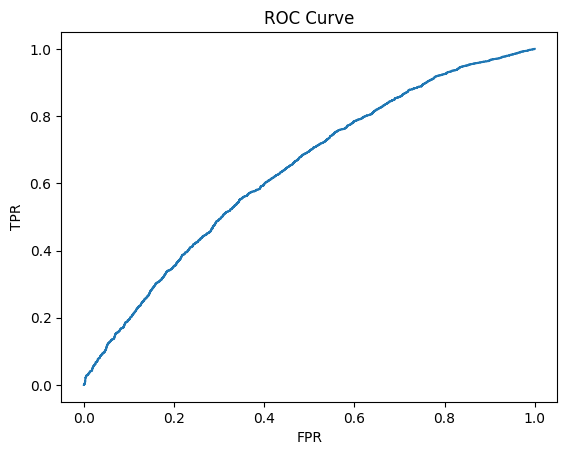

In [ ]:
plot_roc(second_ft_logimodel, "", X_test, y_prob)

In [ ]:
# confusion matrix
print(pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted  False  True   All
Actual                      
0.0           47  1796  1843
1.0           52  7166  7218
All           99  8962  9061


In [ ]:
print("AIC: " + str(second_ft_logimodel.aic))
print("BIC: " + str(second_ft_logimodel.bic_llf))

AIC: 79068.74295078576
BIC: 79580.73571479146


# Prediction of both free throws in a set of 2, using GLM (two logistic regressions)

In [ ]:
N = player_freethrows.shape[0]
train_size = int(N*0.9)

Y = player_freethrows[['1of2', '2of2']]
X = player_freethrows

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, test_size=N-train_size, random_state=1)

selected_quant_feat = [
    'FTA',
    'FT%',
    '3PA',
    '3P%',
    'time',
    'abs_score_diff',
    'exp',
    'G',
    'player_height',
    'player_weight',
]

selected_qual_feat_1 = [
    'prev_shot1_made',
    'prev_shot2_made',
    'Pos_C',
    'Pos_PF',
    'Pos_PG',
    'Pos_SF',
    # 'Pos_SG',
    'period_1.0',
    'period_2.0',
    'period_3.0',
    'period_4.0',
    'period_5.0',
    'period_6.0',
    'period_7.0',
    # 'period_8.0',
    'playoffs_regular'
]

selected_qual_feat_2 = ['1of2'] + selected_qual_feat_1

X_train_1 = X_train[selected_qual_feat_1 + selected_quant_feat]
X_test_1 = X_test[selected_qual_feat_1 + selected_quant_feat]
X_train_1 = sm.add_constant(X_train_1)
X_test_1 = sm.add_constant(X_test_1)

X_train_2 = X_train[selected_qual_feat_2 + selected_quant_feat]
X_test_2 = X_test[selected_qual_feat_2 + selected_quant_feat]
X_train_2 = sm.add_constant(X_train_2)
# X_test_2 = X_test_2.drop('1of2', axis=1)  # to be predicted by first_ft_logimodel
X_test_2 = sm.add_constant(X_test_2)

Y_train_1 = Y_train['1of2']
Y_test_1 = Y_test['1of2']
Y_train_2 = Y_train['2of2']
Y_test_2 = Y_test['2of2']

# additional transformed features
for quant_feat in selected_quant_feat:
  for X_sub in [X_train_1, X_test_1, X_train_2, X_test_2]:
    X_sub[quant_feat + "_sq"] = X_sub[quant_feat] ** 2
    X_sub[quant_feat + "_sqrt"] = X_sub[quant_feat] ** (1/2)
    X_sub[quant_feat + "_cub"] = X_sub[quant_feat] ** 3
    X_sub[quant_feat + "_cubrt"] = X_sub[quant_feat] ** (1/3)
    # X_sub[quant_feat + "_exp"] = np.exp(X_sub[quant_feat])
    # X_sub[quant_feat + "_log"] = np.log(X_sub[quant_feat])

first_ft_logimodel = sm.GLM(Y_train_1, X_train_1, family=sm.families.Binomial()).fit()
print(first_ft_logimodel.summary())
print("\n")
second_ft_logimodel = sm.GLM(Y_train_2, X_train_2, family=sm.families.Binomial()).fit()
print(second_ft_logimodel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   1of2   No. Observations:                81549
Model:                            GLM   Df Residuals:                    81495
Model Family:                Binomial   Df Model:                           53
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34468.
Date:                Tue, 12 Dec 2023   Deviance:                       68936.
Time:                        04:26:45   Pearson chi2:                 8.09e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.2283
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.081e+04 

In [ ]:
print("Model Evaluation")
print()
print("Evaluation of model for first free throw:")
print("AIC: " + str(first_ft_logimodel.aic))
print("BIC: " + str(first_ft_logimodel.bic_llf))
print()
print("Evaluation of model for second free throw:")
print("AIC: " + str(second_ft_logimodel.aic))
print("BIC: " + str(second_ft_logimodel.bic_llf))
print()

Model Evaluation

Evaluation of model for first free throw:
AIC: 69043.59065304755
BIC: 69546.2744577077

Evaluation of model for second free throw:
AIC: 79068.74295105213
BIC: 79580.73571505783



In [ ]:
def plot_roc(model, Y_test, Y_prob):
    fpr, tpr, thresholds = roc_curve(Y_test, Y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")

In [ ]:
Y_pred_1 = first_ft_logimodel.predict(X_test_1) > 0.5

X_test_2 = X_test_2.drop('1of2', axis=1)  # to be predicted by first_ft_logimodel
X_test_2.insert(1, '1of2', Y_pred_1.astype(int))

Y_pred_2 = second_ft_logimodel.predict(X_test_2) > 0.5
Y_pred = Y_pred_1 + Y_pred_2

Evaluation (test set) of prediction for first free throw:

Accuracy (proportion of correct predictions): 0.8321377331420373

Confusion matrix:
Predicted  False  True   All
Actual                      
0.0         1331   900  2231
1.0          621  6209  6830
All         1952  7109  9061



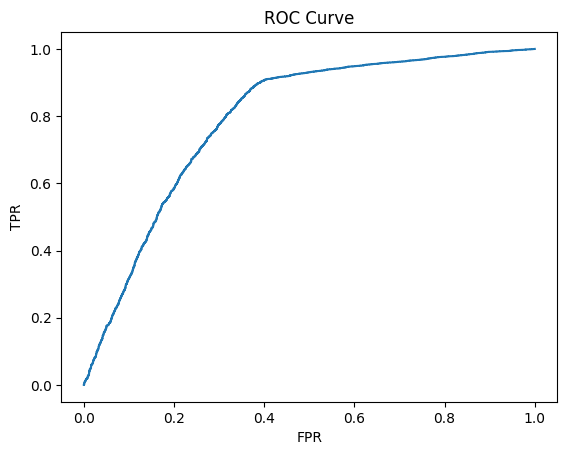

In [ ]:
print("Evaluation (test set) of prediction for first free throw:")
print()
print(f"Accuracy (proportion of correct predictions): {np.mean(Y_test_1 == Y_pred_1)}")
print()
print("Confusion matrix:")
print(pd.crosstab(Y_test_1, Y_pred_1, rownames=['Actual'], colnames=['Predicted'], margins=True))
print()
plot_roc(first_ft_logimodel, Y_test_1, first_ft_logimodel.predict(X_test_1))

Evaluation (test set) of prediction for second free throw:

Accuracy (proportion of correct predictions): 0.7961593643085753

Confusion matrix:
Predicted  False  True   All
Actual                      
0.0           47  1796  1843
1.0           51  7167  7218
All           98  8963  9061



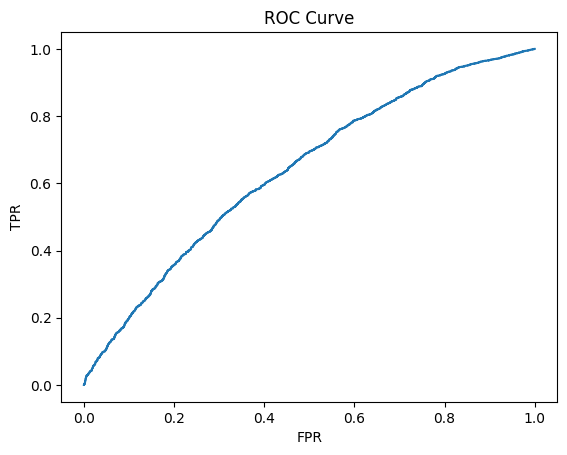

In [ ]:
print("Evaluation (test set) of prediction for second free throw:")
print()
print(f"Accuracy (proportion of correct predictions): {np.mean(Y_test_2 == Y_pred_2)}")
print()
print("Confusion matrix:")
print(pd.crosstab(Y_test_2, Y_pred_2, rownames=['Actual'], colnames=['Predicted'], margins=True))
print()
plot_roc(second_ft_logimodel, Y_test_2, second_ft_logimodel.predict(X_test_2))

In [ ]:
print(f"Overall MSE of test set: {np.mean((Y_pred - (Y_test_1 + Y_test_2)) ** 2)}")

Overall MSE of test set: 0.6812713828495751
